In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patheffects as path_effects

pd.set_option('max_columns', None)

### Load data

In [117]:
#folder = 'finals_2021_1'
#path = '/home/danguyen/data/powertac/finals_2021/{}/analysis'.format(folder)
folder = 'finals_2022_1'
path = '/home/danguyen/data/powertac/finals_2022/{}'.format(folder)
cwd = Path(path)
tf_transactions = pd.read_csv(cwd/"{}.tariff-transactions.csv".format(folder), delimiter=";")
balancing_actions = pd.read_csv(cwd/"{}.broker-balancing-actions.csv".format(folder), delimiter=";", decimal=",")


### Clean data

In [118]:
# remove leading and trailing whitespaces in column names and values

def rem_ws_col(df):
    df.columns = df.columns.str.strip()
    return df

def rem_ws_val(df):
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    return df

tf_transactions = rem_ws_col(tf_transactions)
balancing_actions = rem_ws_col(balancing_actions)

tf_transactions[['broker-name', 'tariff-type', 'transaction-type']].astype(str)
tf_transactions = rem_ws_val(tf_transactions)


### Transform datasets

We assume for now regulation = 1 means it is a balancing event. 
Afterwards we aggregate per broker per timeslot the powertype (tariff-type) and whether it is storing or curtailment (transaction-type).

In [119]:

tf_reg = tf_transactions[tf_transactions['transaction-regulation'] == 1].copy()

tf_reg = tf_reg[['timeslot'
                , 'broker-name'
                , 'tariff-type'
                , 'transaction-type'
                , 'transaction-kWh'
                , 'transaction-charge']]
tf_reg_agg = tf_reg.groupby(by = ['timeslot'
                            , 'broker-name'
                            , 'tariff-type'
                            , 'transaction-type'], as_index=False).sum().copy()
final_tf = tf_reg_agg[tf_reg_agg['transaction-kWh'] != 0].copy()
final_tf


,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge
0,362,VidyutVanika,BATTERY_STORAGE,CONSUME,-855.061995,89.781509
1,362,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-227.161660,23.851974
2,363,VidyutVanika,BATTERY_STORAGE,CONSUME,-1200.000000,126.000000
3,363,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-309.912605,32.540824
4,364,VidyutVanika,BATTERY_STORAGE,CONSUME,-789.885374,82.937964
...,...,...,...,...,...,...
2920,1983,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,PRODUCE,139.221429,-9.543942
2921,1983,VidyutVanika,BATTERY_STORAGE,PRODUCE,721.759046,-140.743014
2923,1984,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,PRODUCE,139.221429,-9.543942
2924,1984,VidyutVanika,BATTERY_STORAGE,PRODUCE,1200.000000,-234.000000


Collapse the dataframe to have individual broker regulation per timeslot observations

In [120]:
df = balancing_actions.copy()
iterations = range(int((len(df.columns)-6)/7))
  
final_ba = pd.DataFrame()

for i in iterations:
    df_basic = df.iloc[:, [0,3]]
    df_data = df.iloc[:, 6+i*7:(i+1)*7+6]
    df_data.columns = ['broker', 'netLoad', 'regOffered', 'regUsed', 'baseCost', 'p1', 'p2']
    df_merge = pd.concat([df_basic,df_data], axis=1)
    final_ba = pd.concat([final_ba, df_merge])
    
final_ba = final_ba[final_ba["regUsed"] != 0 ]

Merge the datasets on timeslot and broker

In [121]:
final_df = final_ba.merge(final_tf, left_on=['ts', 'broker'], right_on=['timeslot', 'broker-name'])
final_df

,ts,totalImbalance,broker,netLoad,regOffered,regUsed,baseCost,p1,p2,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge
0,362,1082.2237,VidyutVanika,-10487.7200,-1427.1617,-1082.2237,466.4663,-466.4663,-48.1345,362,VidyutVanika,BATTERY_STORAGE,CONSUME,-855.061995,89.781509
1,362,1082.2237,VidyutVanika,-10487.7200,-1427.1617,-1082.2237,466.4663,-466.4663,-48.1345,362,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-227.161660,23.851974
2,363,8193.2827,VidyutVanika,-4491.5813,-1509.9126,-1509.9126,120.6404,-120.6404,-30.4638,363,VidyutVanika,BATTERY_STORAGE,CONSUME,-1200.000000,126.000000
3,363,8193.2827,VidyutVanika,-4491.5813,-1509.9126,-1509.9126,120.6404,-120.6404,-30.4638,363,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-309.912605,32.540824
4,364,7503.2036,VidyutVanika,-4745.9390,-1099.7980,-1099.7980,194.6872,-194.6872,-38.0733,364,VidyutVanika,BATTERY_STORAGE,CONSUME,-789.885374,82.937964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1981,-19469.7572,TUC_TAC22,3432.4250,139.2214,139.2214,600.4165,600.4165,27.0445,1981,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,PRODUCE,139.221429,-9.543942
2236,1982,-18636.3011,TUC_TAC22,-28985.2619,139.2214,139.2214,-5528.2092,-5528.2092,29.1282,1982,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,PRODUCE,139.221429,-9.543942
2237,1983,-21603.8635,TUC_TAC22,-29188.6250,139.2214,139.2214,-5716.9127,-276.0948,27.1482,1983,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,PRODUCE,139.221429,-9.543942
2238,1984,-19603.3655,TUC_TAC22,-14410.8964,139.2214,139.2214,-2908.7735,-1185.8267,100.7247,1984,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,PRODUCE,139.221429,-9.543942


## KPI-New: Barplot - per-broker view

In [62]:
df_up = final_df[final_df['transaction-type'] == 'PRODUCE'][['broker', 'regUsed', 'p2', 'transaction-charge', 'tariff-type']].copy()
df_down = final_df[final_df['transaction-type'] == 'CONSUME'][['broker', 'regUsed', 'p2', 'transaction-charge', 'tariff-type']].copy()
tf_transactions[tf_transactions['transaction-regulation'] == 1]['tariff-type'].unique()

customer-name:
    1000 kwh für 1€
    2000 kwh für 0.5€
    
    wäre dann 3000kwh für 2000€ also avg of 66ct pro kwh
    auf customer gerechnet wäre
    1€
    0.5€
    also 0.75€ on avg
    
    get both?

array(['THERMAL_STORAGE_CONSUMPTION', 'STORAGE', 'BATTERY_STORAGE'],
      dtype=object)

In [86]:
tf_transactions[(tf_transactions['transaction-regulation'] == 1) & (tf_transactions['transaction-type'] == 'PRODUCE')]

tf_transactions[tf_transactions['transaction-regulation'] == 1]['broker-name'].unique()

array(['TUC_TAC', 'CrocodileAgent2020', 'IS3'], dtype=object)

In [167]:
regPowertypes = tf_transactions[tf_transactions['transaction-regulation'] == 1]['tariff-type'].unique().tolist()
netCostTf = tf_transactions[(tf_transactions['tariff-type'].isin(regPowertypes)) & 
                           (tf_transactions['transaction-type'].isin(['PRODUCE', 'CONSUME']))][['broker-name'
                                                                                 , 'customer-name'
                                                                                 , 'transaction-kWh'
                                                                                 , 'transaction-charge']].groupby(by = ['broker-name'
                                                                                                                        , 'customer-name'], as_index = False).sum()

netCostTf['perKwh'] = netCostTf['transaction-charge']/netCostTf['transaction-kWh']
netCostTf[['broker-name', 'perKwh']].groupby(by = ['broker-name'], as_index = False).mean()

,broker-name,customer-name,transaction-kWh,transaction-charge,perKwh
0,TUC_TAC22,FrostyStorage,-5.030434e+06,527702.439989,-0.104902
1,TUC_TAC22,fc2,-2.170036e+03,214.635796,-0.098909
2,TUC_TAC22,fc3,-1.241598e+04,1238.057516,-0.099715
3,TUC_TAC22,freezeco-1,-3.184282e+04,3356.097261,-0.105396
4,TUC_TAC22,freezeco-2,-5.794023e+04,6483.326203,-0.111897
5,TUC_TAC22,freezeco-3,-3.032231e+04,2830.037592,-0.093332
6,TUC_TAC22,seafood-1,-8.751576e+04,7861.041625,-0.089824
7,TUC_TAC22,seafood-2,-4.613498e+04,4181.475878,-0.090636
8,TUC_TAC22,sf2,-4.711986e+03,470.243833,-0.099797
9,TUC_TAC22,sf3,-2.189489e+04,2174.575773,-0.099319


In [171]:
regPowertypes = tf_transactions[tf_transactions['transaction-regulation'] == 1]['tariff-type'].unique().tolist()
netCostTf = tf_transactions[(tf_transactions['tariff-type'].isin(regPowertypes)) & 
                           (tf_transactions['transaction-type'].isin(['PRODUCE', 'CONSUME']))][['broker-name'
                                                                                 , 'transaction-kWh'
                                                                                 , 'transaction-charge']].groupby(by = ['broker-name'], as_index = False).sum()

netCostTf['perKwh'] = netCostTf['transaction-charge']/netCostTf['transaction-kWh']
netCostTf = netCostTf[['broker-name', 'perKwh']]
netCostTf

,broker-name,perKwh
0,TUC_TAC22,-0.104502
1,VidyutVanika,-0.064384


In [153]:
tf_transactions[(tf_transactions['transaction-regulation'] == 1) & (tf_transactions['transaction-type'] == 'PRODUCE')]

,game,timeslot,broker-name,tariff-id,tariff-type,transaction-type,transaction-kWh,transaction-charge,transaction-regulation,customer-name,customer-count,test
6129,finals_2022_1,377,TUC_TAC22,500000131,THERMAL_STORAGE_CONSUMPTION,PRODUCE,21.743102,-1.490538,1,freezeco-2,1,21.743102
6132,finals_2022_1,377,TUC_TAC22,500000131,THERMAL_STORAGE_CONSUMPTION,PRODUCE,6942.885863,-475.950431,1,FrostyStorage,3,6942.885863
6431,finals_2022_1,378,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,40.000000,-7.800000,1,b1,1,40.000000
6432,finals_2022_1,378,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,40.000000,-7.800000,1,b2,1,40.000000
6433,finals_2022_1,378,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,40.000000,-7.800000,1,b3,1,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
575640,finals_2022_1,1984,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,40.000000,-7.800000,1,b30,1,40.000000
575642,finals_2022_1,1984,TUC_TAC22,500000131,THERMAL_STORAGE_CONSUMPTION,PRODUCE,76.650000,-5.254530,1,freezeco-2,1,76.650000
575643,finals_2022_1,1984,TUC_TAC22,500000131,THERMAL_STORAGE_CONSUMPTION,PRODUCE,62.571429,-4.289412,1,freezeco-1,1,62.571429
576032,finals_2022_1,1985,TUC_TAC22,500000131,THERMAL_STORAGE_CONSUMPTION,PRODUCE,76.650000,-5.254530,1,freezeco-2,1,76.650000


In [166]:
df_down

#positive transaaction charge means broker gets paid, customer pays

,broker,regUsed,p2,transaction-charge,tariff-type
0,VidyutVanika,-1082.2237,-48.1345,89.781509,BATTERY_STORAGE
1,VidyutVanika,-1082.2237,-48.1345,23.851974,THERMAL_STORAGE_CONSUMPTION
2,VidyutVanika,-1509.9126,-30.4638,126.000000,BATTERY_STORAGE
3,VidyutVanika,-1509.9126,-30.4638,32.540824,THERMAL_STORAGE_CONSUMPTION
4,VidyutVanika,-1099.7980,-38.0733,82.937964,BATTERY_STORAGE
...,...,...,...,...,...
2143,TUC_TAC22,-3124.2985,575.5887,47.825907,THERMAL_STORAGE_CONSUMPTION
2152,TUC_TAC22,-433.8010,2.2617,6.640506,THERMAL_STORAGE_CONSUMPTION
2158,TUC_TAC22,-607.0395,159.2072,9.292394,THERMAL_STORAGE_CONSUMPTION
2183,TUC_TAC22,-961.7280,49.6232,14.721868,THERMAL_STORAGE_CONSUMPTION


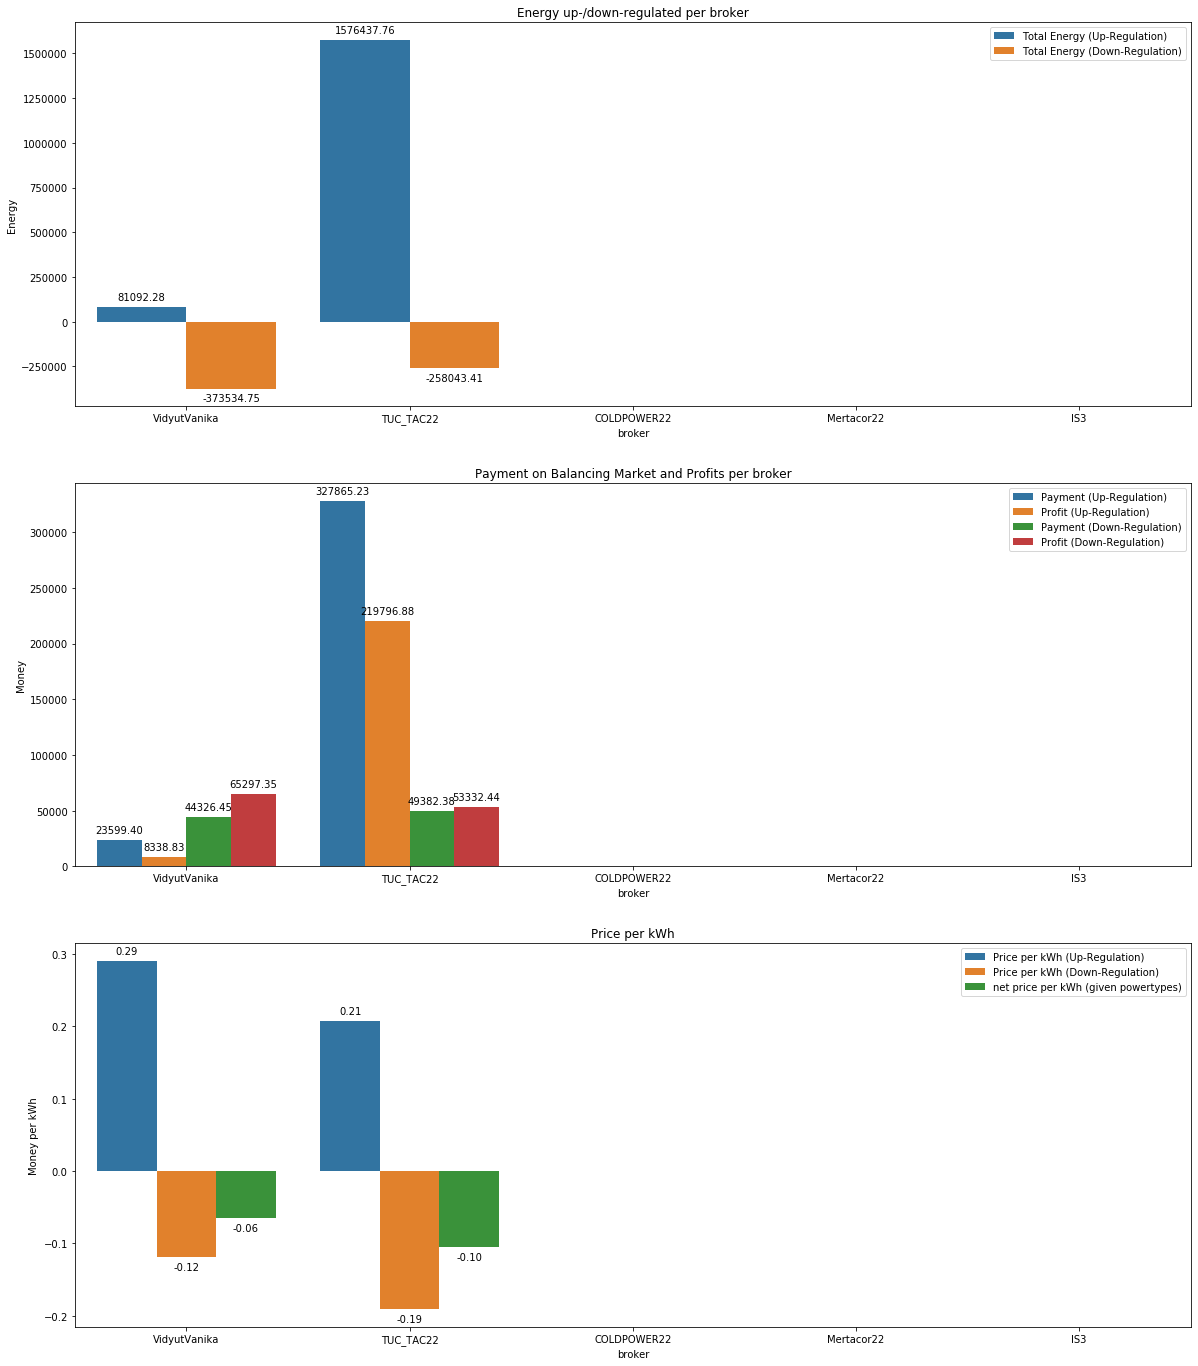

In [178]:
# up-regulation = produce or curtail, down-regulation = consume or store
# positive means giving the market energy, negative means withdrawing energy from the market
# positive transaction-charge means pay broker, negative means broker pays
# for p2 it means positive is bm_broker pays broker, negative means broker pays


#per broker: how much energy did you give and get, how much 
#    per thermalstorageconsumption, and batterystorage - 
#    for all do it across all tariff types given in transaction regulation == 1

broker_list = tf_transactions['broker-name'].unique().tolist()
final_broker_list = [x for x in broker_list if x != 'default broker']
broker_df = pd.DataFrame(final_broker_list, columns = ['broker'])

df_up = final_df[final_df['transaction-type'] == 'PRODUCE'][['broker', 'regUsed', 'p2', 'transaction-charge', 'tariff-type']].copy()
df_down = final_df[final_df['transaction-type'] == 'CONSUME'][['broker', 'regUsed', 'p2', 'transaction-charge', 'tariff-type']].copy()

df_up_reg = df_up[['broker', 'regUsed', 'p2', 'transaction-charge']].copy()
df_up_reg = df_up_reg.groupby(by = ['broker'], as_index = False).sum()

df_up_reg['regUsed'] = df_up_reg['regUsed'].apply(lambda x: round(x, 2))
df_up_reg['p2'] = df_up_reg['p2'].apply(lambda x: round(x, 2))
df_up_reg['transaction-charge'] = df_up_reg['transaction-charge'].apply(lambda x: round(x, 2))
df_up_reg['profit'] = df_up_reg['p2'] + df_up_reg['transaction-charge']

df_up_reg.columns = ['broker', 'upReg', 'pUp_fromBroker', 'pUp_toCustomer', 'profit']


df_down_reg = df_down[['broker', 'regUsed', 'p2', 'transaction-charge']].copy()
df_down_reg = df_down_reg.groupby(by = ['broker'], as_index = False).sum()

df_down_reg['regUsed'] = df_down_reg['regUsed'].apply(lambda x: round(x, 2))
df_down_reg['p2'] = df_down_reg['p2'].apply(lambda x: round(x, 2))
df_down_reg['transaction-charge'] = df_down_reg['transaction-charge'].apply(lambda x: round(x, 2))
df_down_reg['profit'] = df_down_reg['p2'] + df_down_reg['transaction-charge']

df_down_reg.columns = ['broker', 'downReg', 'pDown_toBroker', 'pDown_fromCustomer', 'profit']

df_merge = broker_df.merge(df_up_reg, on = ['broker'], how = 'left')
df_merge = df_merge.merge(df_down_reg, on = ['broker'], how = 'left')

df_up_reg['sellPrice'] = df_up_reg['pUp_fromBroker']/df_up_reg['upReg']
df_down_reg['buyPrice'] = df_down_reg['pDown_toBroker']/df_down_reg['downReg']

sellPrice = df_up_reg[['broker', 'sellPrice']].copy()
buyPrice = df_down_reg[['broker', 'buyPrice']].copy()

regPowertypes = tf_transactions[tf_transactions['transaction-regulation'] == 1]['tariff-type'].unique().tolist()
netCostTf = tf_transactions[(tf_transactions['tariff-type'].isin(regPowertypes)) & 
                           (tf_transactions['transaction-type'].isin(['PRODUCE', 'CONSUME']))][['broker-name'
                                                                                 , 'transaction-kWh'
                                                                                 , 'transaction-charge']].groupby(by = ['broker-name'], as_index = False).sum()

netCostTf['perKwh'] = netCostTf['transaction-charge']/netCostTf['transaction-kWh']
netCostTf = netCostTf[['broker-name', 'perKwh']]
netCostTf.columns = ['broker', 'perKwh']

df_perKwh = broker_df.merge(sellPrice, on = ['broker'], how = 'left')
df_perKwh = df_perKwh.merge(buyPrice, on = ['broker'], how = 'left')
df_perKwh = df_perKwh.merge(netCostTf, on = ['broker'], how = 'left')

# Use melt to reshape the dataframe
df_melt_energy = pd.melt(df_merge, id_vars=['broker'], value_vars=['upReg', 'downReg'])
df_melt_profit = pd.melt(df_merge, id_vars=['broker'], value_vars=['pUp_fromBroker', 'profit_x', 'pDown_toBroker', 'profit_y'])
df_melt_perKwh = pd.melt(df_perKwh, id_vars=['broker'], value_vars=['sellPrice', 'buyPrice', 'perKwh'])

# Create a bar plot

f, axes = plt.subplots(3,1, figsize = (20,24))

a = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_energy, ax=axes[0])
b = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_profit, ax=axes[1])
c = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_perKwh, ax=axes[2])

new_labels = ['Total Energy (Up-Regulation)', 'Total Energy (Down-Regulation)']
                                               
h, l = a.get_legend_handles_labels()
a.legend(h, new_labels, loc = "upper right")

new_labels = ['Payment (Up-Regulation)', 'Profit (Up-Regulation)'
                                               , 'Payment (Down-Regulation)', 'Profit (Down-Regulation)']
h, l = b.get_legend_handles_labels()
b.legend(h, new_labels, loc = "upper right")

new_labels = ['Price per kWh (Up-Regulation)', 'Price per kWh (Down-Regulation)'
                                               , 'net price per kWh (given powertypes)']
h, l = c.get_legend_handles_labels()
c.legend(h, new_labels, loc = "upper right")



def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


add_value_labels(a)
add_value_labels(b)
add_value_labels(c)

axes[0].set(ylabel="Energy")
axes[1].set(ylabel="Money")
axes[2].set(ylabel="Money per kWh")

axes[0].set_title("Energy up-/down-regulated per broker")
axes[1].set_title("Payment on Balancing Market and Profits per broker")
axes[2].set_title("Price per kWh")

plt.show()


In [ ]:
change colorways
3 additional columns to plot

!!!!!!!!! 3 subplots with barplots, to have similar scales?


2 barplots maybe, one with per kwh view and one with total sum view, values on top of bar/ relative values

4 barplots per broker
regused per broker grouped, twice for up and downregulation
payments received for up-regulation / there is a shortage and i provide energy by curtailing (PRODUCE), i get paid but i pay customer too
payments done for down-regulation / there is excess and i store energy by using more (CONSUME), i pay others but customer pays me (less) too

profit made by up-regulation per broker after subtracting customer
profit made by down-regulation per broker after subtracting customer


price for each kwh sold on bm - to just have an absolute number as comparison
price for each kwh bought on bm - to just have an absolute number as comparison
net charging cost for customer (for that powertype)
    without any tariff specs from up-front payments, should i include? is just a join i guess on tariffid


do the powertype specification again


In [41]:
df_down

,broker,regUsed,p2,transaction-charge,tariff-type
0,CrocodileAgent2020,-21.3416,-0.5184,3.201238,STORAGE
1,CrocodileAgent2020,-23.0584,-0.4821,3.458762,STORAGE
2,CrocodileAgent2020,-22.0000,-0.4735,3.300000,STORAGE
3,CrocodileAgent2020,-23.8320,-0.7280,3.574806,STORAGE
4,CrocodileAgent2020,-17.0560,-0.5846,2.558395,STORAGE
...,...,...,...,...,...
2357,TUC_TAC,-2104.8681,-11.9384,45.295894,THERMAL_STORAGE_CONSUMPTION
2358,TUC_TAC,-7354.9109,-3.1020,158.274654,THERMAL_STORAGE_CONSUMPTION
2359,TUC_TAC,-2220.3910,-11.6705,47.781900,THERMAL_STORAGE_CONSUMPTION
2360,TUC_TAC,-3371.7469,-14.9408,72.558606,THERMAL_STORAGE_CONSUMPTION


In [45]:
df_down[df_down['p2']>0]


,broker,regUsed,p2,transaction-charge,tariff-type
17,CrocodileAgent2020,-5.9681,72.0892,0.895214,STORAGE
18,CrocodileAgent2020,-5.3821,272.7275,0.807313,STORAGE
26,CrocodileAgent2020,-1.1000,373.5766,0.165000,STORAGE
27,CrocodileAgent2020,-3.8230,472.4841,0.573443,STORAGE
28,CrocodileAgent2020,-1.0575,386.2534,0.158618,STORAGE
...,...,...,...,...,...
2287,TUC_TAC,-2455.1859,262.4409,52.834591,THERMAL_STORAGE_CONSUMPTION
2288,TUC_TAC,-3582.3349,164.3687,77.090374,THERMAL_STORAGE_CONSUMPTION
2296,TUC_TAC,-10435.7765,113.0774,224.573614,THERMAL_STORAGE_CONSUMPTION
2321,TUC_TAC,-9096.5022,180.1774,195.752984,THERMAL_STORAGE_CONSUMPTION


In [48]:
final_df

,ts,totalImbalance,broker,netLoad,regOffered,regUsed,baseCost,p1,p2,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge
0,366,"626,7082",VidyutVanika,"-3614,8012","-1625,7751","-626,7082","180,3626","-180,3626","-31,2700",366,VidyutVanika,BATTERY_STORAGE,CONSUME,-200.933110,21.097977
1,366,"626,7082",VidyutVanika,"-3614,8012","-1625,7751","-626,7082","180,3626","-180,3626","-31,2700",366,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-425.775127,44.706388
2,367,"22233,7957",VidyutVanika,"17533,4184","-1808,4373","-1808,4373","-529,4279","529,4279","-17,6684",367,VidyutVanika,BATTERY_STORAGE,CONSUME,-1200.000000,126.000000
3,367,"22233,7957",VidyutVanika,"17533,4184","-1808,4373","-1808,4373","-529,4279","529,4279","-17,6684",367,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-608.437290,63.885915
4,368,"32144,7853",VidyutVanika,"27309,4247","-1820,1626","-1820,1626","-327,3865","327,3865","33,3756",368,VidyutVanika,BATTERY_STORAGE,CONSUME,-1200.000000,126.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,519,"5390,2749",VidyutVanika,"-13356,5526","-339,1371","-339,1371","577,4965","-577,4965","-12,9502",519,VidyutVanika,BATTERY_STORAGE,CONSUME,-1.421053,0.149211
81,519,"5390,2749",VidyutVanika,"-13356,5526","-339,1371","-339,1371","577,4965","-577,4965","-12,9502",519,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-337.716050,38.178788
82,521,"4634,5080",VidyutVanika,"-10696,9427","-266,5118","-266,5118","408,7609","-408,7609","-9,0201",521,VidyutVanika,BATTERY_STORAGE,CONSUME,-2.842105,0.298421
83,521,"4634,5080",VidyutVanika,"-10696,9427","-266,5118","-266,5118","408,7609","-408,7609","-9,0201",521,VidyutVanika,THERMAL_STORAGE_CONSUMPTION,CONSUME,-263.669715,29.807852


In [57]:
medians

NameError: name 'medians' is not defined

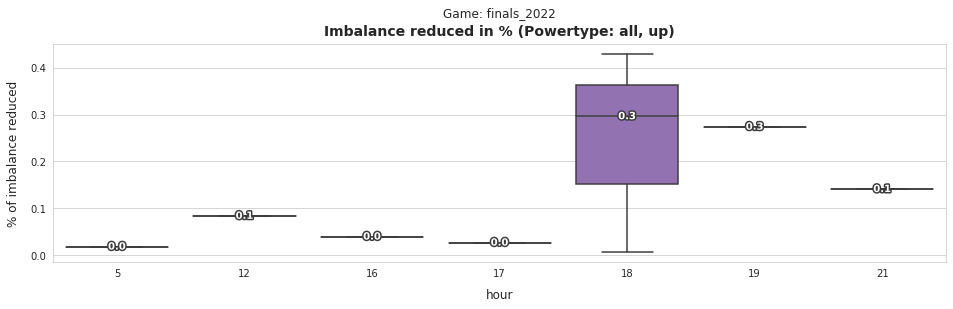

In [82]:
def kpi1_imb(final_df, powertype, imbalance, game):
    imb_pattern = r".*" if imbalance == 'both' else 'PRODUCE' if imbalance == 'up' else 'CONSUME'
    powertype_pattern = r".*" if powertype == 'all' else powertype

    kpi1_imb_up = final_df[(final_df['transaction-type'].str.match(imb_pattern)) ][['ts', 'totalImbalance']].copy()
    kpi1_imb_up['totalImbalance'] = abs(kpi1_imb_up['totalImbalance'].astype(int))
    kpi1_imb_up = kpi1_imb_up.groupby(by = ['ts'], as_index = False).sum().copy()

    kpi1_reg_up = final_df[(final_df['transaction-type'].str.match(imb_pattern)) 
                           & (final_df['tariff-type'].str.match(powertype_pattern))][['ts', 'regUsed']].copy()
    kpi1_reg_up['regUsed'] = abs(kpi1_reg_up['regUsed'])
    kpi1_reg_up = kpi1_reg_up.groupby(by = ['ts'], as_index = False).sum().copy()

    kpi1_perc = kpi1_imb_up.merge(kpi1_reg_up, on = ['ts'], how = 'left')

    kpi1_perc['hour'] = kpi1_perc['ts'] % 24
    kpi1_perc['perc'] = kpi1_perc['regUsed'] / kpi1_perc['totalImbalance']

    powertype_dict = {'BATTERY_STORAGE': 'Battery Storage', 'PRODUCTION': 'Production', 'STORAGE': 'Storage'
                      , 'CONSUMPTION': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION' : 'Solar Production', 'WIND_PRODUCTION': 'Wind Production', 'all':'all'}

    sns.set_style("whitegrid")



    f = plt.figure(figsize=(16,4))

    mid = (f.subplotpars.right + f.subplotpars.left)/2


    box_plot = sns.boxplot(x='hour', y='perc', data=kpi1_perc)
    plt.suptitle('Imbalance reduced in % (Powertype: {0}, {1})'.format(powertype_dict[powertype], imbalance)
                   , y = 0.95
                   , x = mid
                   , fontsize = 14,
                    fontweight = 'bold')
    plt.title('Game: {}'.format(game), y = 1.1)

    plt.ylabel('% of imbalance reduced', fontsize=12, labelpad=10)
    plt.xlabel('hour', fontsize=12, labelpad=10)

    #plt.yticks(np.arange(0, 1.01, 0.2))
    
    def add_median_labels(ax, fmt='.1f'):
        lines = ax.get_lines()
        boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
        lines_per_box = int(len(lines) / len(boxes))
        for median in lines[4:len(lines):lines_per_box]:
            x, y = (data.mean() for data in median.get_data())
            # choose value depending on horizontal or vertical plot orientation
            value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
            text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                           fontweight='bold', color='white')
            # create median-colored border around white text for contrast
            text.set_path_effects([
                path_effects.Stroke(linewidth=3, foreground=median.get_color()),
                path_effects.Normal(),
            ])



    add_median_labels(box_plot)

    plt.show()
    
        
kpi1_imb(final_df, 'all', 'up', 'finals_2022')

## KPI1: Boxplot - Imbalance fixed across brokers per power type

0.006831854850326263


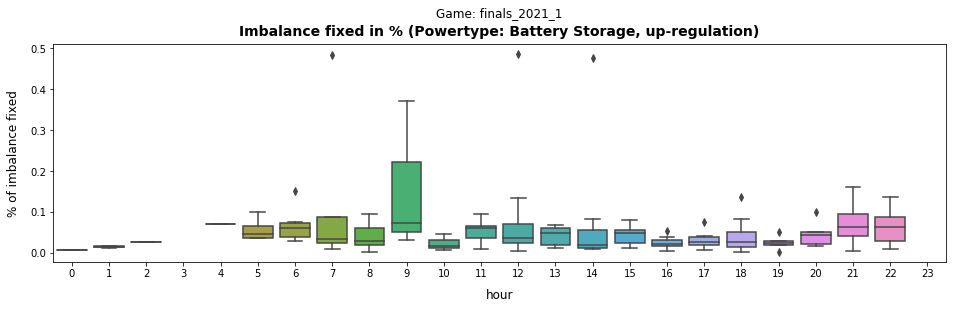

In [29]:
# up-regulation means shortage and therefore produce/ curtail energy resulting in more energy available
# down-regulation means excess and therefore consume/ storage energy resulting in more energy used
# consume is down-regulation or storage, produce is up-regulation or curtailment
# dots outside are determined outliers

def kpi1_imb(powertype, imbalance):
    
    imb_pattern = r".*" if imbalance == 'both' else 'PRODUCE' if imbalance == 'up-regulation' else 'CONSUME'
    powertype_pattern = r".*" if powertype == 'all' else powertype

    kpi1_imb_up = final_df[(final_df['transaction-type'].str.match(imb_pattern)) ][['ts', 'totalImbalance']].copy()
    kpi1_imb_up['totalImbalance'] = abs(kpi1_imb_up['totalImbalance'])
    kpi1_imb_up = kpi1_imb_up.groupby(by = ['ts'], as_index = False).sum().copy()

    kpi1_reg_up = final_df[(final_df['transaction-type'].str.match(imb_pattern)) 
                           & (final_df['tariff-type'].str.match(powertype_pattern))][['ts', 'regUsed']].copy()
    kpi1_reg_up['regUsed'] = abs(kpi1_reg_up['regUsed'])
    kpi1_reg_up = kpi1_reg_up.groupby(by = ['ts'], as_index = False).sum().copy()

    kpi1_perc = kpi1_imb_up.merge(kpi1_reg_up, on = ['ts'], how = 'left')

    kpi1_perc['hour'] = kpi1_perc['ts'] % 24
    kpi1_perc['perc'] = kpi1_perc['regUsed'] / kpi1_perc['totalImbalance']
    
    powertype_dict = {'BATTERY_STORAGE': 'Battery Storage', 'PRODUCTION': 'Production', 'STORAGE': 'Storage'
                      , 'CONSUMPTION': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION' : 'Solar Production', 'WIND_PRODUCTION': 'Wind Production', 'all':'all'}

    
    f = plt.figure(figsize=(16,4))
    
    mid = (f.subplotpars.right + f.subplotpars.left)/2

    plot = sns.boxplot(x='hour', y='perc', data=kpi1_perc)
    plt.suptitle('Imbalance fixed in % (Powertype: {0}, {1})'.format(powertype_dict[powertype], imbalance)
                   , y = 0.95
                   , x = mid
                   , fontsize = 14,
                    fontweight = 'bold')
    plt.title('Game: {}'.format(folder), y = 1.1)

    plt.ylabel('% of imbalance fixed', fontsize=12, labelpad=10)
    plt.xlabel('hour', fontsize=12, labelpad=10)
    
    print(kpi1_perc['regUsed'].sum()/kpi1_perc['totalImbalance'].sum())
    
kpi1_imb('BATTERY_STORAGE','up-regulation')




## KPI2: Line Plot - Share of each Power Type in controlling capacity

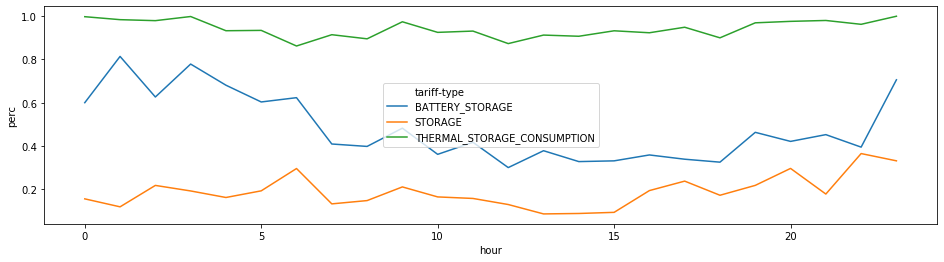

In [34]:


# additionally do it per imbalance side

#def kpi2_share():
    
kpi2_total = final_df[['ts', 'regUsed']].copy()
kpi2_total['regUsed'] = abs(kpi2_total['regUsed'])
kpi2_total = kpi2_total.groupby(by = ['ts'], as_index = False).sum().copy()

kpi2_reg = final_df[['ts', 'regUsed', 'tariff-type']].copy()

kpi2_reg['regUsed'] = abs(kpi2_reg['regUsed'])
kpi2_reg = kpi2_reg.groupby(by = ['ts', 'tariff-type'], as_index = False).sum().copy()

kpi2_perc = kpi2_total.merge(kpi2_reg, on = ['ts'], how = 'left')
kpi2_perc['hour'] = kpi2_perc['ts'] % 24

kpi2_perc['perc'] = kpi2_perc['regUsed_y'] / kpi2_perc['regUsed_x']

kpi2_perc2 = kpi2_perc[['hour', 'perc', 'tariff-type']].copy()
kpi2_perc2 = kpi2_perc2.groupby(by = ['hour', 'tariff-type'], as_index = False).mean()

# up-regulation means shortage and therefore produce/ curtail energy resulting in more energy available
# down-regulation means excess and therefore consume/ storage energy resulting in more energy used
# consume is down-regulation or storage, produce is up-regulation or curtailment
# dots outside are determined outliers

f = plt.figure(figsize=(16,4))

sns.lineplot(x="hour", y="perc", hue="tariff-type", data=kpi2_perc2)




In [ ]:
 kpi1_perc['hour'] = kpi1_perc['ts'] % 24
    kpi1_perc['perc'] = kpi1_perc['regUsed'] / kpi1_perc['totalImbalance']

    f = plt.figure(figsize=(16,4))

    sns.boxplot(x='hour', y='perc', data=kpi1_perc)
    print(kpi1_perc['regUsed'].sum()/kpi1_perc['totalImbalance'].sum())
    
kpi1_imb('BATTERY_STORAGE','up')

In [35]:
kpi2_perc2

,hour,tariff-type,perc
0,0,BATTERY_STORAGE,0.599973
1,0,STORAGE,0.154899
2,0,THERMAL_STORAGE_CONSUMPTION,0.997930
3,1,BATTERY_STORAGE,0.814037
4,1,STORAGE,0.117970
...,...,...,...
67,22,STORAGE,0.364468
68,22,THERMAL_STORAGE_CONSUMPTION,0.962649
69,23,BATTERY_STORAGE,0.705876
70,23,STORAGE,0.330890


In [ ]:
kpi1_df_og = final_df[['ts', 'broker', 'regUsed', 'tariff-type', 'transaction-type', 'transaction-kWh']].copy()
kpi1_df_og['absImbalance'] = abs(kpi1_df_og['totalImbalance'])
kpi1_df_og['absRegulation'] = abs(kpi1_df_og['regUsed'])


kpi1_df = kpi1_df_og[['ts', 'absImbalance', ]]
kpi1_df_og['hour'] = kpi1_df_og['ts'] % 24
kpi1_df['hour'] = kpi1_df['ts'] % 24
kpi1_df['absImbalance'] = abs(kpi1_df['totalImbalance'])
kpi1_df['absRegulation'] = abs(kpi1_df['regUsed'])
kpi1_df['fixedImbalance'] = kpi1_df['absRegulation']/kpi1_df['absImbalance']
kpi1_df

In [76]:
kpi1_df['tariff-type'].unique()

array(['STORAGE', 'BATTERY_STORAGE', 'THERMAL_STORAGE_CONSUMPTION'],
      dtype=object)

In [79]:
kpi1_df[kpi1_df['tariff-type'] == 'THERMAL_STORAGE_CONSUMPTION']['transaction-type'].unique()

array(['PRODUCE', 'CONSUME'], dtype=object)

In [82]:
kpi1_df[kpi1_df['totalImbalance'] > 0]['transaction-type'].unique()

array(['CONSUME'], dtype=object)

In [116]:
final_df

,ts,totalImbalance,broker,netLoad,regOffered,regUsed,baseCost,p1,p2,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge
0,368,7800.1454,CrocodileAgent2020,-1176.6784,-21.3416,-21.3416,34.9099,-26.5582,-0.5184,368,CrocodileAgent2020,STORAGE,CONSUME,-21.341584,3.201238
1,369,10473.1373,CrocodileAgent2020,-1175.2770,-23.0584,-23.0584,34.0314,-28.7303,-0.4821,369,CrocodileAgent2020,STORAGE,CONSUME,-23.058416,3.458762
2,370,7910.8427,CrocodileAgent2020,108.6552,-22.0000,-22.0000,-3.0989,2.8415,-0.4735,370,CrocodileAgent2020,STORAGE,CONSUME,-22.000000,3.300000
3,371,2319.2942,CrocodileAgent2020,122.0125,-23.8320,-23.8320,-4.0068,4.0023,-0.7280,371,CrocodileAgent2020,STORAGE,CONSUME,-23.832043,3.574806
4,377,706.6961,CrocodileAgent2020,704.0833,-17.0560,-17.0560,-24.6080,24.0260,-0.5846,377,CrocodileAgent2020,STORAGE,CONSUME,-17.055964,2.558395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,1709,16266.0400,TUC_TAC,-1432.6330,-5862.3624,-2220.3910,27.6451,-3.7735,-11.6705,1709,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-2220.391002,47.781900
2360,1713,17094.9008,TUC_TAC,2731.7338,-4447.5904,-3371.7469,-49.5573,9.7769,-14.9408,1713,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-3371.746938,72.558606
2361,1714,15544.2776,TUC_TAC,1183.9542,-4710.9329,-1799.9449,-23.3455,0.8189,-10.7578,1714,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-1799.944926,38.734074
2362,1715,-6262.0299,TUC_TAC,-16336.6395,4938.8566,4938.8566,-2743.9118,-2743.9118,824.2150,1715,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,4938.856644,-360.825790
